In [37]:
# Cell 2
import os
import glob
import time
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# For EEG
import mne

# Seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)


TF version: 2.14.1


In [38]:
# Cell 3 - change these where needed
DATA_DIR = "./dataverse_files"            # path to your EDF files
OUT_DIR = "./processed"        # where processed X/y will be saved
os.makedirs(OUT_DIR, exist_ok=True)

# Preprocessing parameters (Option B)
TARGET_SFREQ = 250            # target sampling freq (paper uses 250)
NOTCH_FREQ = 50.0             # mains notch (change to 60 if needed)
BANDPASS_LO = 1.0
BANDPASS_HI = 45.0

# Segmenting
EPOCH_SECS = 25               # paper: 25 seconds
EPOCH_SAMPLES = int(EPOCH_SECS * TARGET_SFREQ)

# ICA settings
USE_ICA = True                # recommended True in Option B
ICA_N_COMPONENTS = 15

# Training settings (paper-inspired)
BATCH_SIZE = 16
EPOCHS_NON_SUBJECT = 70      # non-subject paper uses 70
EPOCHS_SUBJECT = 50          # subject-based paper uses 50

# Model params
LEARNING_RATE_NON_SUBJECT = 1e-4
LEARNING_RATE_SUBJECT = 1e-3

# Channels from paper (10-20)
PAPER_CHANNELS = ['Fp1','Fp2','F7','F3','Fz','F4','F8',
                  'T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2']


In [39]:
# Cell 4
def read_raw_edf_file(path):
    """
    Try loading EDF with mne. If it fails, raise error to make it explicit.
    """
    try:
        raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
        return raw
    except Exception as e:
        # try pyedflib-based load via mne RawArray construction (rare)
        try:
            import pyedflib
            f = pyedflib.EdfReader(path)
            ch_names = f.getSignalLabels()
            n = f.signals_in_file
            sfreq = f.getSampleFrequency(0)
            data = np.zeros((n, f.getNSamples()[0]), dtype=float)
            for i in range(n):
                data[i, :] = f.readSignal(i)
            f._close()
            info = mne.create_info(ch_names, sfreq, ch_types='eeg')
            raw = mne.io.RawArray(data, info)
            return raw
        except Exception as e2:
            raise RuntimeError(f"Could not read {path} via mne or pyedflib: {e} / {e2}")


In [40]:
# Cell 5
def preprocess_raw(raw, target_sfreq=TARGET_SFREQ, notch_freq=NOTCH_FREQ,
                   l_freq=BANDPASS_LO, h_freq=BANDPASS_HI, use_ica=USE_ICA, ica_n_components=ICA_N_COMPONENTS):
    # Pick EEG channels only initially
    raw.pick_types(eeg=True, exclude=[])
    
    # Fix common channel name issues (strip spaces)
    raw.rename_channels({ch: ch.strip() for ch in raw.ch_names})
    
    # Resample if needed
    if int(raw.info['sfreq']) != target_sfreq:
        raw.resample(target_sfreq, npad='auto', verbose=False)
    
    # Notch filter
    if notch_freq:
        raw.notch_filter(freqs=[notch_freq], picks='eeg', verbose=False)
    
    # Bandpass
    raw.filter(l_freq, h_freq, picks='eeg', verbose=False)
    
    # Re-reference to average (common reference for scalp EEG)
    raw.set_eeg_reference('average', verbose=False)
    
    # Optional ICA to remove EOG/blink: we will try to auto-detect EOG if eog channel present.
    if use_ica:
        try:
            ica = mne.preprocessing.ICA(n_components=ica_n_components, random_state=SEED, max_iter='auto')
            ica.fit(raw)
            # Try auto-detect EOG-like components if EOG channel present
            eog_inds, scores = ica.find_bads_eog(raw, ch_name=None, threshold=3.0)  # may return []
            ica.exclude = eog_inds
            raw = ica.apply(raw.copy())
        except Exception as e:
            # If ICA fails, proceed without it (but log)
            print("ICA failed or skipped:", e)
    
    return raw


In [41]:

# Cell 6
def epoch_raw(raw, epoch_secs=EPOCH_SECS, epoch_samples=EPOCH_SAMPLES, selected_channels=PAPER_CHANNELS):
    """
    raw: mne Raw after preprocessing
    returns: numpy array shape (n_epochs, n_channels, epoch_samples) and list of indices of channels used
    """
    # intersect paper channels with available channels
    available = raw.ch_names
    selected = [ch for ch in selected_channels if ch in available]
    if len(selected) == 0:
        selected = available  # fallback to all EEG channels
    
    # pick selected channels (work on a copy)
    raw_sel = raw.copy().pick_channels(selected)
    data = raw_sel.get_data()  # shape (n_ch, n_times)
    n_ch, n_t = data.shape
    
    # how many full non-overlapping epochs
    n_epochs = n_t // epoch_samples
    if n_epochs == 0:
        return np.empty((0, n_ch, epoch_samples), dtype=np.float32), selected
    
    epochs = []
    for i in range(n_epochs):
        start = i * epoch_samples
        seg = data[:, start:start+epoch_samples].astype(np.float32)
        # small artifact rejection threshold: if any value extreme -> skip
        if np.any(np.abs(seg) > 500e-6):  # 500 uV threshold
            continue
        # z-score per channel
        mean = seg.mean(axis=1, keepdims=True)
        std = seg.std(axis=1, keepdims=True) + 1e-8
        seg = (seg - mean) / std
        epochs.append(seg)
    if len(epochs) == 0:
        return np.empty((0, n_ch, epoch_samples), dtype=np.float32), selected
    return np.stack(epochs, axis=0), selected


In [42]:
# Cell 7
def preprocess_folder(data_dir=DATA_DIR, out_dir=OUT_DIR):
    edf_files = sorted(glob.glob(os.path.join(data_dir, "*.edf")))
    if len(edf_files) == 0:
        raise FileNotFoundError(f"No EDF files found in {data_dir}")
    X_parts = []
    y_parts = []
    subj_parts = []
    channels_used = None
    for fpath in edf_files:
        fname = os.path.basename(fpath)
        print("Loading:", fname)
        raw = read_raw_edf_file(fpath)
        raw = preprocess_raw(raw)
        epochs, sel_chs = epoch_raw(raw)
        if channels_used is None:
            channels_used = sel_chs
        # Infer label: filenames that start with 's' or contain 'sz' -> 1 else 0 when 'h' prefix -> 0
        lab = 1 if (fname.lower().startswith('s') or 'sz' in fname.lower()) else 0
        if epochs.shape[0] == 0:
            print("No usable epochs for", fname)
            continue
        X_parts.append(epochs)  # (n_e, n_ch, n_samples)
        y_parts.extend([lab]*epochs.shape[0])
        subj_parts.extend([fname]*epochs.shape[0])
        print(f"  -> {epochs.shape[0]} epochs, channels={len(sel_chs)}")
    if len(X_parts) == 0:
        raise RuntimeError("No epochs extracted from dataset.")
    X = np.concatenate(X_parts, axis=0)
    y = np.array(y_parts, dtype=np.int32)
    subjects = np.array(subj_parts)
    # Save
    np.save(os.path.join(out_dir, "X.npy"), X)
    np.save(os.path.join(out_dir, "y.npy"), y)
    np.save(os.path.join(out_dir, "subjects.npy"), subjects)
    # Save channels list
    pd.Series(channels_used).to_csv(os.path.join(out_dir, "channels_used.csv"), index=False)
    print("Saved processed data to", out_dir)
    print("Shapes: X:", X.shape, "y:", y.shape, "subjects:", subjects.shape)
    unique, counts = np.unique(y, return_counts=True)
    print("Label distribution:", dict(zip(unique.tolist(), counts.tolist())))
    return X, y, subjects

# Run preprocessing (this will take some minutes)
X, y, subjects = preprocess_folder(DATA_DIR, OUT_DIR)
# For safety while testing, uncomment above line to execute.


Loading: h01.edf
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.8s.
ICA failed or skipped: No EOG channel(s) found
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  -> 37 epochs, channels=19
Loading: h02.edf
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.0s.
ICA failed or skipped: No EOG channel(s) found
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  -> 36 epochs, channels=19
Loading: h03.edf
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA to

X.shape: (1111, 19, 6250)
y.shape: (1111,)
subjects.shape: (1111,)
Label counts: {0: 499, 1: 612}
Channels used: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']


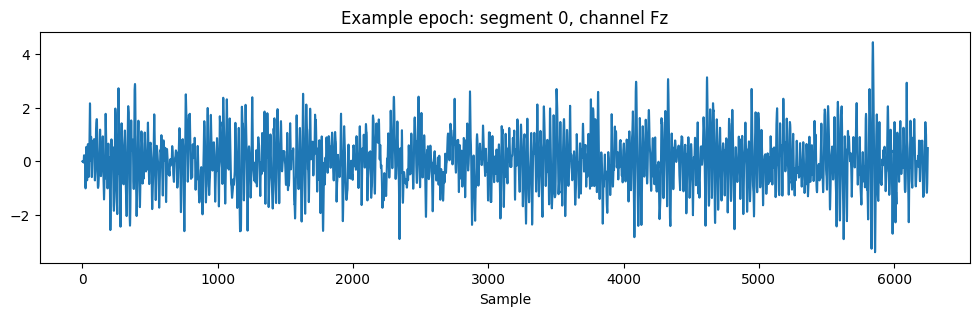

In [43]:
# Cell 8
# Run after preprocessing
import numpy as np, os
X = np.load(os.path.join(OUT_DIR, "X.npy"))
y = np.load(os.path.join(OUT_DIR, "y.npy"))
subjects = np.load(os.path.join(OUT_DIR, "subjects.npy"), allow_pickle=True)
print("X.shape:", X.shape)            # (n_segments, n_channels, 6250)
print("y.shape:", y.shape)
print("subjects.shape:", subjects.shape)
unique, counts = np.unique(y, return_counts=True)
print("Label counts:", dict(zip(unique.tolist(), counts.tolist())))

# Plot one example epoch (first segment, channel index of Fz if present)
ch_list = pd.read_csv(os.path.join(OUT_DIR, "channels_used.csv")).iloc[:,0].tolist()
print("Channels used:", ch_list)
ch_idx = ch_list.index('Fz') if 'Fz' in ch_list else 0
plt.figure(figsize=(12,3))
plt.plot(X[0, ch_idx, :])
plt.title(f"Example epoch: segment 0, channel {ch_list[ch_idx]}")
plt.xlabel("Sample")
plt.show()


In [44]:
# Robust compute_metrics (paste & run)
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np

def compute_metrics(y_true, y_pred):
    # Ensure labels are ints
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    # Force confusion matrix labels [0,1] to always get 2x2
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # cm is 2x2 now
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total if total > 0 else None
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else None
    specificity = tn / (tn + fp) if (tn + fp) > 0 else None
    precision = tp / (tp + fp) if (tp + fp) > 0 else None
    return {"accuracy": accuracy, "sensitivity": sensitivity, "specificity": specificity,
            "precision": precision, "tn": int(tn),"fp":int(fp),"fn":int(fn),"tp":int(tp)}


In [45]:
# Cell 10
def build_cnn_non_subject(input_shape, lr=LEARNING_RATE_NON_SUBJECT):
    """
    A Conv1D model inspired by the paper. input_shape = (timesteps, channels)
    We'll use Conv1D along the time axis. The paper uses many conv/pool layers; we mimic depth and pooling.
    """
    inp = layers.Input(shape=input_shape)  # (timesteps, channels)
    x = inp
    # Conv block 1
    x = layers.Conv1D(16, kernel_size=10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    # Block 2
    x = layers.Conv1D(32, kernel_size=10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.25)(x)
    # Block 3
    x = layers.Conv1D(64, kernel_size=10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    # Flatten and FCs (paper uses 3 FC)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)   # paper used 0.5 in FC for non-subject
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [46]:
# Cell 11
def build_cnn_subject_based(input_shape, lr=LEARNING_RATE_SUBJECT):
    inp = layers.Input(shape=input_shape)
    x = inp
    # Conv + maxpool + avgpool pattern
    x = layers.Conv1D(16, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.AveragePooling1D(2)(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.AveragePooling1D(2)(x)
    x = layers.Conv1D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # paper applied dropout earlier in subject model; keep 0.5
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [47]:
# Cell 12
def get_callbacks(prefix, out_dir=OUT_DIR):
    ts = int(time.time())
    ckpt = callbacks.ModelCheckpoint(os.path.join(out_dir, f"{prefix}_best_{ts}.h5"),
                                     monitor='val_loss', save_best_only=True)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    return [ckpt, es, rlr]


In [48]:
# Cell 13
def train_non_subject(X, y, n_splits=10, epochs=EPOCHS_NON_SUBJECT, batch_size=BATCH_SIZE):
    #X shape (N, n_ch, n_samples) #-> we used shape (n_segments, n_channels, seg_len)
    # For Conv1D with time axis as first dim expected (timesteps, channels) so we transpose
    X_in = np.transpose(X, (0, 2, 1))  # (N, timesteps, channels)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_results = []
    fold = 0
    for train_idx, test_idx in skf.split(X_in, y):
        fold += 1
        print(f"\n--- Fold {fold}/{n_splits} ---")
        X_train, X_test = X_in[train_idx], X_in[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # further split validation from train (e.g., 80/20)
        val_split = int(0.8 * len(train_idx))
        # Alternatively use sklearn train_test_split; here just use last 20% as val
        # Build model
        model = build_cnn_non_subject(input_shape=X_train.shape[1:])
        cbs = get_callbacks(f"non_subject_fold{fold}")
        history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs,
                            batch_size=batch_size, callbacks=cbs, verbose=2)
        # Evaluate
        y_prob = model.predict(X_test).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        metrics = compute_metrics(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_prob)
            metrics['roc_auc'] = auc
        except Exception:
            metrics['roc_auc'] = None
        print("Fold metrics:", metrics)
        fold_results.append(metrics)
    return fold_results

# Usage after preprocessing:
X = np.load(os.path.join(OUT_DIR,'X.npy'))
non_subject_results = train_non_subject(X, y)



--- Fold 1/10 ---
Epoch 1/70
50/50 - 10s - loss: 1.1308 - accuracy: 0.5131 - val_loss: 0.7098 - val_accuracy: 0.3000 - lr: 1.0000e-04 - 10s/epoch - 195ms/step
Epoch 2/70


c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 7s - loss: 0.8381 - accuracy: 0.5044 - val_loss: 0.7782 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 7s/epoch - 148ms/step
Epoch 3/70
50/50 - 9s - loss: 0.7233 - accuracy: 0.5344 - val_loss: 0.6971 - val_accuracy: 0.0100 - lr: 1.0000e-04 - 9s/epoch - 188ms/step
Epoch 4/70
50/50 - 7s - loss: 0.6925 - accuracy: 0.5569 - val_loss: 0.7004 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 7s/epoch - 141ms/step
Epoch 5/70
50/50 - 7s - loss: 0.6947 - accuracy: 0.5394 - val_loss: 0.7004 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 7s/epoch - 148ms/step
Epoch 6/70
50/50 - 9s - loss: 0.6928 - accuracy: 0.5657 - val_loss: 0.7030 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 9s/epoch - 189ms/step
Epoch 7/70
50/50 - 15s - loss: 0.6914 - accuracy: 0.5620 - val_loss: 0.7051 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 15s/epoch - 304ms/step
Epoch 8/70
50/50 - 15s - loss: 0.6920 - accuracy: 0.5594 - val_loss: 0.7071 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 15s/epoch - 302ms/step
Epoch 9/70
50/50 -

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 22s - loss: 1.1801 - accuracy: 0.5312 - val_loss: 0.7757 - val_accuracy: 0.0150 - lr: 1.0000e-04 - 22s/epoch - 441ms/step
Epoch 2/70
50/50 - 16s - loss: 0.7437 - accuracy: 0.5200 - val_loss: 0.7100 - val_accuracy: 0.1950 - lr: 1.0000e-04 - 16s/epoch - 318ms/step
Epoch 3/70
50/50 - 17s - loss: 0.7044 - accuracy: 0.5362 - val_loss: 0.7681 - val_accuracy: 0.0300 - lr: 1.0000e-04 - 17s/epoch - 347ms/step
Epoch 4/70
50/50 - 16s - loss: 0.6892 - accuracy: 0.5250 - val_loss: 0.7274 - val_accuracy: 0.1150 - lr: 1.0000e-04 - 16s/epoch - 324ms/step
Epoch 5/70
50/50 - 16s - loss: 0.6929 - accuracy: 0.5350 - val_loss: 0.7713 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 16s/epoch - 316ms/step
Epoch 6/70
50/50 - 15s - loss: 0.6839 - accuracy: 0.5425 - val_loss: 0.7430 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 15s/epoch - 305ms/step
Epoch 7/70
50/50 - 16s - loss: 0.6889 - accuracy: 0.5412 - val_loss: 0.6968 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 16s/epoch - 315ms/step
Epoch 8/70
5

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 20s - loss: 1.2628 - accuracy: 0.5238 - val_loss: 0.7367 - val_accuracy: 0.1400 - lr: 1.0000e-04 - 20s/epoch - 406ms/step
Epoch 2/70
50/50 - 241s - loss: 0.8565 - accuracy: 0.5350 - val_loss: 0.6679 - val_accuracy: 0.7950 - lr: 1.0000e-04 - 241s/epoch - 5s/step
Epoch 3/70
50/50 - 10s - loss: 0.7297 - accuracy: 0.5175 - val_loss: 0.7806 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 10s/epoch - 192ms/step
Epoch 4/70
50/50 - 7s - loss: 0.6988 - accuracy: 0.5587 - val_loss: 0.6970 - val_accuracy: 0.0300 - lr: 1.0000e-04 - 7s/epoch - 138ms/step
Epoch 5/70
50/50 - 7s - loss: 0.6930 - accuracy: 0.5612 - val_loss: 0.7135 - val_accuracy: 0.0400 - lr: 1.0000e-04 - 7s/epoch - 137ms/step
Epoch 6/70
50/50 - 8s - loss: 0.6926 - accuracy: 0.5400 - val_loss: 0.7001 - val_accuracy: 0.0450 - lr: 1.0000e-04 - 8s/epoch - 152ms/step
Epoch 7/70
50/50 - 7s - loss: 0.6924 - accuracy: 0.5650 - val_loss: 0.7024 - val_accuracy: 0.0450 - lr: 1.0000e-04 - 7s/epoch - 140ms/step
Epoch 8/70
50/50 - 12s - loss

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 7s - loss: 0.7856 - accuracy: 0.5462 - val_loss: 0.7305 - val_accuracy: 0.2200 - lr: 1.0000e-04 - 7s/epoch - 141ms/step
Epoch 3/70
50/50 - 7s - loss: 0.7127 - accuracy: 0.5600 - val_loss: 0.7207 - val_accuracy: 0.2150 - lr: 1.0000e-04 - 7s/epoch - 142ms/step
Epoch 4/70
50/50 - 7s - loss: 0.6894 - accuracy: 0.5100 - val_loss: 0.7034 - val_accuracy: 0.6050 - lr: 1.0000e-04 - 7s/epoch - 136ms/step
Epoch 5/70
50/50 - 13s - loss: 0.6921 - accuracy: 0.5013 - val_loss: 0.7051 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 13s/epoch - 254ms/step
Epoch 6/70
50/50 - 13s - loss: 0.6728 - accuracy: 0.5612 - val_loss: 0.7398 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 13s/epoch - 262ms/step
Epoch 7/70
50/50 - 14s - loss: 0.6928 - accuracy: 0.5450 - val_loss: 0.6941 - val_accuracy: 0.1700 - lr: 1.0000e-04 - 14s/epoch - 274ms/step
Epoch 8/70
50/50 - 13s - loss: 0.6967 - accuracy: 0.5625 - val_loss: 0.6949 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 13s/epoch - 261ms/step
Epoch 9/70
50/50 - 7s - loss: 

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 7s - loss: 0.9062 - accuracy: 0.5000 - val_loss: 0.6637 - val_accuracy: 1.0000 - lr: 1.0000e-04 - 7s/epoch - 135ms/step
Epoch 3/70
50/50 - 7s - loss: 0.8039 - accuracy: 0.5512 - val_loss: 0.6985 - val_accuracy: 0.5150 - lr: 1.0000e-04 - 7s/epoch - 149ms/step
Epoch 4/70
50/50 - 9s - loss: 0.7121 - accuracy: 0.5200 - val_loss: 0.6906 - val_accuracy: 0.6700 - lr: 1.0000e-04 - 9s/epoch - 187ms/step
Epoch 5/70
50/50 - 10s - loss: 0.6924 - accuracy: 0.5575 - val_loss: 0.7013 - val_accuracy: 0.0350 - lr: 1.0000e-04 - 10s/epoch - 210ms/step
Epoch 6/70
50/50 - 7s - loss: 0.6925 - accuracy: 0.5512 - val_loss: 0.6967 - val_accuracy: 0.0150 - lr: 1.0000e-04 - 7s/epoch - 134ms/step
Epoch 7/70
50/50 - 7s - loss: 0.6856 - accuracy: 0.5663 - val_loss: 0.7383 - val_accuracy: 0.0100 - lr: 5.0000e-05 - 7s/epoch - 133ms/step
Epoch 8/70
50/50 - 7s - loss: 0.6785 - accuracy: 0.5650 - val_loss: 0.7595 - val_accuracy: 0.0100 - lr: 5.0000e-05 - 7s/epoch - 141ms/step
Epoch 9/70
50/50 - 7s - loss: 0.6761

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 8s - loss: 0.8376 - accuracy: 0.5100 - val_loss: 0.7052 - val_accuracy: 0.2250 - lr: 1.0000e-04 - 8s/epoch - 154ms/step
Epoch 3/70
50/50 - 8s - loss: 0.7285 - accuracy: 0.5175 - val_loss: 0.7446 - val_accuracy: 0.1250 - lr: 1.0000e-04 - 8s/epoch - 155ms/step
Epoch 4/70
50/50 - 7s - loss: 0.6950 - accuracy: 0.4563 - val_loss: 0.6930 - val_accuracy: 0.9800 - lr: 1.0000e-04 - 7s/epoch - 134ms/step
Epoch 5/70
50/50 - 7s - loss: 0.7215 - accuracy: 0.4975 - val_loss: 0.7572 - val_accuracy: 0.3450 - lr: 1.0000e-04 - 7s/epoch - 148ms/step
Epoch 6/70
50/50 - 7s - loss: 0.6981 - accuracy: 0.4875 - val_loss: 0.6937 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 7s/epoch - 139ms/step
Epoch 7/70
50/50 - 7s - loss: 0.6937 - accuracy: 0.5612 - val_loss: 0.6948 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 7s/epoch - 138ms/step
Epoch 8/70
50/50 - 7s - loss: 0.6923 - accuracy: 0.5612 - val_loss: 0.6960 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 7s/epoch - 145ms/step
Epoch 9/70
50/50 - 7s - lo

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 7s - loss: 0.7394 - accuracy: 0.4950 - val_loss: 0.6949 - val_accuracy: 0.0550 - lr: 1.0000e-04 - 7s/epoch - 140ms/step
Epoch 3/70
50/50 - 8s - loss: 0.6934 - accuracy: 0.5587 - val_loss: 0.7083 - val_accuracy: 0.0250 - lr: 1.0000e-04 - 8s/epoch - 168ms/step
Epoch 4/70
50/50 - 13s - loss: 0.6934 - accuracy: 0.5500 - val_loss: 0.6940 - val_accuracy: 0.1350 - lr: 1.0000e-04 - 13s/epoch - 260ms/step
Epoch 5/70
50/50 - 14s - loss: 0.6989 - accuracy: 0.5587 - val_loss: 0.6973 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 14s/epoch - 274ms/step
Epoch 6/70
50/50 - 19s - loss: 0.6924 - accuracy: 0.5550 - val_loss: 0.8166 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 19s/epoch - 374ms/step
Epoch 7/70
50/50 - 16s - loss: 0.6933 - accuracy: 0.5462 - val_loss: 0.7091 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 16s/epoch - 315ms/step
Epoch 8/70
50/50 - 10s - loss: 0.6919 - accuracy: 0.5425 - val_loss: 0.7028 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 10s/epoch - 190ms/step
Epoch 9/70
50/50

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 10s - loss: 1.1831 - accuracy: 0.5125 - val_loss: 0.7010 - val_accuracy: 0.3900 - lr: 1.0000e-04 - 10s/epoch - 190ms/step
Epoch 2/70
50/50 - 12s - loss: 0.7865 - accuracy: 0.5113 - val_loss: 0.6973 - val_accuracy: 0.3150 - lr: 1.0000e-04 - 12s/epoch - 243ms/step
Epoch 3/70
50/50 - 13s - loss: 0.6946 - accuracy: 0.5350 - val_loss: 0.7416 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 13s/epoch - 258ms/step
Epoch 4/70
50/50 - 8s - loss: 0.6907 - accuracy: 0.5387 - val_loss: 0.6996 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 8s/epoch - 164ms/step
Epoch 5/70
50/50 - 11s - loss: 0.6913 - accuracy: 0.5638 - val_loss: 0.7023 - val_accuracy: 0.0150 - lr: 1.0000e-04 - 11s/epoch - 218ms/step
Epoch 6/70
50/50 - 11s - loss: 0.6926 - accuracy: 0.5575 - val_loss: 0.7018 - val_accuracy: 0.1150 - lr: 1.0000e-04 - 11s/epoch - 228ms/step
Epoch 7/70
50/50 - 12s - loss: 0.6910 - accuracy: 0.5525 - val_loss: 0.7095 - val_accuracy: 0.0300 - lr: 1.0000e-04 - 12s/epoch - 240ms/step
Epoch 8/70
50/50 - 8s 

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 20s - loss: 1.2763 - accuracy: 0.5038 - val_loss: 0.7914 - val_accuracy: 0.0400 - lr: 1.0000e-04 - 20s/epoch - 408ms/step
Epoch 2/70
50/50 - 13s - loss: 0.7606 - accuracy: 0.5125 - val_loss: 0.6956 - val_accuracy: 0.0600 - lr: 1.0000e-04 - 13s/epoch - 264ms/step
Epoch 3/70
50/50 - 16s - loss: 0.6948 - accuracy: 0.5500 - val_loss: 0.6975 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 16s/epoch - 311ms/step
Epoch 4/70
50/50 - 8s - loss: 0.6969 - accuracy: 0.5562 - val_loss: 0.6999 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 8s/epoch - 165ms/step
Epoch 5/70
50/50 - 12s - loss: 0.6930 - accuracy: 0.5512 - val_loss: 0.7022 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 12s/epoch - 231ms/step
Epoch 6/70
50/50 - 13s - loss: 0.6917 - accuracy: 0.5638 - val_loss: 0.7041 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 13s/epoch - 266ms/step
Epoch 7/70
50/50 - 13s - loss: 0.6924 - accuracy: 0.5562 - val_loss: 0.7067 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 13s/epoch - 268ms/step
Epoch 

c:\Users\tapes\OneDrive\Desktop\Schizophrenia Detection\eeg_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 - 7s - loss: 0.8212 - accuracy: 0.5063 - val_loss: 0.7756 - val_accuracy: 0.0250 - lr: 1.0000e-04 - 7s/epoch - 149ms/step
Epoch 3/70
50/50 - 7s - loss: 0.7507 - accuracy: 0.5138 - val_loss: 0.6989 - val_accuracy: 0.0950 - lr: 1.0000e-04 - 7s/epoch - 141ms/step
Epoch 4/70
50/50 - 6s - loss: 0.6927 - accuracy: 0.5550 - val_loss: 0.7081 - val_accuracy: 0.0400 - lr: 1.0000e-04 - 6s/epoch - 129ms/step
Epoch 5/70
50/50 - 7s - loss: 0.6868 - accuracy: 0.5475 - val_loss: 0.7137 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 7s/epoch - 138ms/step
Epoch 6/70
50/50 - 7s - loss: 0.6855 - accuracy: 0.5500 - val_loss: 0.6964 - val_accuracy: 0.1800 - lr: 1.0000e-04 - 7s/epoch - 140ms/step
Epoch 7/70
50/50 - 7s - loss: 0.6965 - accuracy: 0.5675 - val_loss: 0.7015 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04 - 7s/epoch - 140ms/step
Epoch 8/70
50/50 - 7s - loss: 0.6910 - accuracy: 0.5663 - val_loss: 0.7033 - val_accuracy: 0.0050 - lr: 1.0000e-04 - 7s/epoch - 139ms/step
Epoch 9/70
50/50 - 7s - loss: 0.69

In [49]:
# cell 14, Robust subject-based trainer that skips folds with single-class test sets
def train_subject_based_safe(X, y, subjects, epochs=EPOCHS_SUBJECT, batch_size=BATCH_SIZE, skip_single_class_test=True):
    X_in = np.transpose(X, (0, 2, 1))  # (N, timesteps, channels)
    unique_subjects = np.unique(subjects)
    results = []
    skipped = []
    for idx_test, subj_test in enumerate(unique_subjects):
        val_index = (idx_test + 1) % len(unique_subjects)
        subj_val = unique_subjects[val_index]
        train_mask = np.logical_and(subjects != subj_test, subjects != subj_val)
        val_mask = (subjects == subj_val)
        test_mask = (subjects == subj_test)
        X_train, y_train = X_in[train_mask], y[train_mask]
        X_val, y_val = X_in[val_mask], y[val_mask]
        X_test, y_test = X_in[test_mask], y[test_mask]
        if X_test.shape[0] == 0:
            skipped.append((subj_test, "no test samples"))
            print(f"Skipping {subj_test}: no test samples")
            continue
        if skip_single_class_test and len(np.unique(y_test)) < 2:
            skipped.append((subj_test, f"single class in test: {np.unique(y_test).tolist()}"))
            print(f"Skipping {subj_test}: test set has single class -> {np.unique(y_test).tolist()}")
            continue
        print(f"Training fold: test={subj_test}, val={subj_val} -> train={X_train.shape[0]} val={X_val.shape[0]} test={X_test.shape[0]}")
        model = build_cnn_subject_based(input_shape=X_train.shape[1:])
        cbs = get_callbacks(f"subject_{subj_test}")
        model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=epochs, batch_size=batch_size, callbacks=cbs, verbose=2)
        y_prob = model.predict(X_test).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        metrics = compute_metrics(y_test, y_pred)
        try:
            metrics['roc_auc'] = roc_auc_score(y_test, y_prob) if len(np.unique(y_test))>1 else None
        except:
            metrics['roc_auc'] = None
        print("Fold metrics:", metrics)
        results.append((str(subj_test), metrics))
    print("Done. Evaluated folds:", len(results), "Skipped folds:", len(skipped))
    if skipped:
        print("Skipped details:", skipped)
    return results

# Use this function instead of the old one:
subject_results = train_subject_based_safe(X, y, subjects)


Skipping h01.edf: test set has single class -> [0]
Skipping h02.edf: test set has single class -> [0]
Skipping h03.edf: test set has single class -> [0]
Skipping h04.edf: test set has single class -> [0]
Skipping h05.edf: test set has single class -> [0]
Skipping h06.edf: test set has single class -> [0]
Skipping h07.edf: test set has single class -> [0]
Skipping h08.edf: test set has single class -> [0]
Skipping h09.edf: test set has single class -> [0]
Skipping h10.edf: test set has single class -> [0]
Skipping h11.edf: test set has single class -> [0]
Skipping h12.edf: test set has single class -> [0]
Skipping h13.edf: test set has single class -> [0]
Skipping h14.edf: test set has single class -> [0]
Skipping s01.edf: test set has single class -> [1]
Skipping s02.edf: test set has single class -> [1]
Skipping s03.edf: test set has single class -> [1]
Skipping s04.edf: test set has single class -> [1]
Skipping s05.edf: test set has single class -> [1]
Skipping s06.edf: test set has 

In [50]:
# Cell 16
def aggregate_results_non_subject(results):
    # results: list of dicts per fold
    import numpy as np
    keys = results[0].keys()
    agg = {}
    for k in keys:
        vals = [r[k] for r in results if r[k] is not None]
        agg[k+"_mean"] = np.mean(vals) if len(vals)>0 else None
        agg[k+"_std"] = np.std(vals) if len(vals)>0 else None
    return agg

# Example save:
import json
with open(os.path.join(OUT_DIR, "non_subject_results.json"), "w") as f:
      json.dump(non_subject_results, f)


# Cell 17 (Markdown)
**Tips before full run**
- Try preprocessing and extract just 1 epoch per subject by temporarily setting EPOCH_SECS smaller (e.g., 5s) to verify pipeline.
- Use smaller model / fewer epochs for a smoke test.
- Monitor GPU usage: `nvidia-smi` if available.
- Set `USE_ICA=False` if ICA is causing long runtimes or failing.
- If memory issues occur, you can use generators and train on batches from disk rather than loading full X into RAM.


In [ ]:
# Cell 18
# If X is too large for RAM, implement a Keras Sequence that yields batches from .npy files on disk.
from tensorflow.keras.utils import Sequence

class EEGSequence(Sequence):
    def __init__(self, X_path, y_path, batch_size=32, shuffle=True):
        self.X = np.load(X_path, mmap_mode='r')
        self.y = np.load(y_path, mmap_mode='r')
        self.batch_size = batch_size
        self.indices = np.arange(len(self.y))
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))
    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        Xb = self.X[batch_idx]
        # transpose to (batch, timesteps, channels)
        Xb = np.transpose(Xb, (0,2,1))
        yb = self.y[batch_idx]
        return Xb, yb
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Cell 19 (Markdown)
You now have:
- A complete preprocessing pipeline (with notch, bandpass, resampling, ICA, segmentation, z-score).
- Two CNN model builders matching the paper's spirit (non-subject and subject variants).
- Training loops for 10-fold non-subject CV and subject-based 14-fold CV.
- Utilities for metrics and saving outputs.

Next steps I can do for you (choose one):
1. Run the preprocessing here on your uploaded EDFs and show `X.shape` + label counts.
2. Run a quick smoke-test training (1-fold or 1 epoch) to ensure model code runs on your environment (recommended).
3. Run the full non-subject 10-fold training and return fold metrics.
4. Run the full subject-based LOSO training and return fold metrics.

Tell me which one to execute first (1–4) or run the notebook locally — either way I’ll support you. 🚀
